# Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np

import glob
import cv2

import matplotlib.pyplot as plt

# Load Dataset

In [3]:
list_train_image = glob.glob("C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/train/images/*")
path_train_label = "C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/train/labels/"

list_val_image = glob.glob("C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/valid/images/*")
path_val_label = "C:/Users/PC_ML/Desktop/Gun_Knife_Censor/Dataset/guns-knives-yolo/guns-knives-yolo/valid/labels/"

In [4]:
def data_loader(list_train_image,path_train_label):
    list_train_x = []
    list_train_y_coff = []
    list_train_y_bbox = []
    
    for file_image in list_train_image:
        file_name = file_image.split("\\")[1].replace(".jpg","")
        file_label = path_train_label+file_name+".txt"
    
        #Read Image
        img = cv2.imread(file_image)
        #Resize
        img = cv2.resize(img, (300,300), interpolation = cv2.INTER_AREA)
        #Normalize Image
        img = img/255.0
        #Add to list
        list_train_x.append(img)
    
        #Read Label
        label = np.zeros((14,5)) # 14 max object in one image 5 is coff,x,y,w,h
        with open(file_label) as file:
            for i,line in enumerate(file.readlines()):
                _line = line.split()
                x = float(_line[1])
                y = float(_line[2])
                w = float(_line[3])
                h = float(_line[4])
                label[i] = np.array([1.0,x,y,w,h])
        #label = label.reshape(14*5)
        list_train_y_coff.append(label[:,0])
        list_train_y_bbox.append(label[:,1:].reshape(14*4))
    
    list_train_x = np.asarray(list_train_x)
    list_train_y_coff = np.asarray(list_train_y_coff)
    list_train_y_bbox = np.asarray(list_train_y_bbox)
    return list_train_x,list_train_y_coff,list_train_y_bbox

In [5]:
train_x,train_y_coff,train_y_bbox = data_loader(list_train_image,path_train_label)
val_x,val_y_coff,val_y_bbox = data_loader(list_val_image,path_val_label)

In [6]:
print(f"train_x:{train_x.shape}")
print(f"train_y_coff:{train_y_coff.shape}")
print(f"train_y_bbox:{train_y_bbox.shape}")
print(f"val_x:{val_x.shape}")
print(f"val_y_coff:{val_y_coff.shape}")
print(f"val_y_bbox:{val_y_bbox.shape}")

train_x:(5241, 300, 300, 3)
train_y_coff:(5241, 14)
train_y_bbox:(5241, 56)
val_x:(1089, 300, 300, 3)
val_y_coff:(1089, 14)
val_y_bbox:(1089, 56)


# Build Model

In [7]:
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(70, activation='relu'))
# model.summary()

input = layers.Input(shape=(300, 300, 3))
con1 = layers.Conv2D(32, (3, 3), activation='relu')(input)
max1 = layers.MaxPooling2D((2, 2))(con1)
con2 = layers.Conv2D(64, (3, 3), activation='relu')(max1) 
max2 = layers.MaxPooling2D((2, 2))(con2)
con3 = layers.Conv2D(64, (3, 3), activation='relu')(max2) 
flat = layers. Flatten()(con3)
h1 = layers.Dense(64, activation='relu')(flat)
h2 = layers.Dense(64, activation='relu')(h1)
out_coff = layers.Dense(14, activation='sigmoid',name="out_coff")(h2)
out_bbox = layers.Dense(56, activation='relu', name="out_bbox")(h2)

model = Model(inputs=input, outputs=[out_coff,out_bbox])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 298, 298, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 149, 149, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [8]:
print(f"Model_input_shape:{model.input_shape}")
print(f"Model_output_shape:{model.output_shape}")

Model_input_shape:(None, 300, 300, 3)
Model_output_shape:[(None, 14), (None, 56)]


# Train Model

In [9]:
losses = {
	"out_coff": "binary_crossentropy",
	"out_bbox": "mae",
}
model.compile(optimizer='adam',loss=losses)

filepath = 'model/model_best_val.keras'
save_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,save_best_only=True, period=1,mode='min')

history = model.fit(x=train_x, y={"out_coff":train_y_coff,"out_bbox":train_y_bbox}, epochs=1000,batch_size=32, validation_data=(val_x, {"out_coff":val_y_coff,"out_bbox":val_y_bbox}),callbacks=[save_checkpoint])

model.save('model/model_final.keras')

Epoch 1/1000
164/164 [==============================] - ETA: 0s - loss: 0.1523 - out_coff_loss: 0.1072 - out_bbox_loss: 0.0451
Epoch 1: val_loss improved from inf to 0.08780, saving model to model\model_best_val.keras
164/164 [==============================] - 127s 495ms/step - loss: 0.1523 - out_coff_loss: 0.1072 - out_bbox_loss: 0.0451 - val_loss: 0.0878 - val_out_coff_loss: 0.0657 - val_out_bbox_loss: 0.0221
Epoch 2/1000
164/164 [==============================] - ETA: 0s - loss: 0.0955 - out_coff_loss: 0.0739 - out_bbox_loss: 0.0215
Epoch 2: val_loss improved from 0.08780 to 0.08328, saving model to model\model_best_val.keras
164/164 [==============================] - 16s 97ms/step - loss: 0.0955 - out_coff_loss: 0.0739 - out_bbox_loss: 0.0215 - val_loss: 0.0833 - val_out_coff_loss: 0.0616 - val_out_bbox_loss: 0.0217
Epoch 3/1000
164/164 [==============================] - ETA: 0s - loss: 0.0877 - out_coff_loss: 0.0663 - out_bbox_loss: 0.0213
Epoch 3: val_loss did not improve from 0.

# Plot Loss

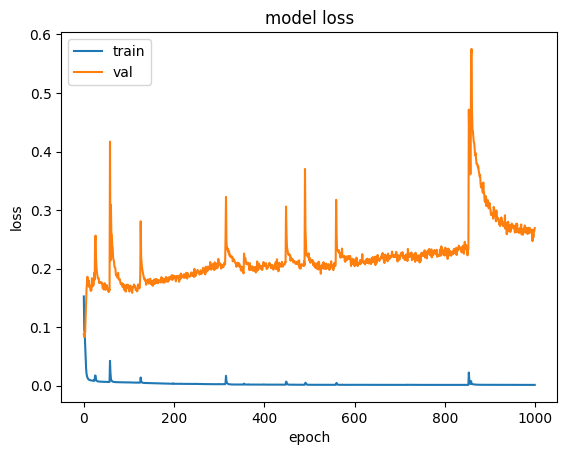

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')